In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
mkdir /content/dataset/

In [3]:
mkdir /content/dataset/initialPath

In [4]:
mkdir /content/dataset/finalPath

In [5]:
! unzip "gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/dataset/breast-histopathology-images" -d /content/dataset/initialPath

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.p

In [6]:
mkdir /content/output

In [7]:
mkdir /content/utils

In [8]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/config.py' '/content/utils/config.py'

In [9]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/conv_bc_model.py' '/content/utils/conv_bc_model.py'

In [10]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/create_dataset.py' '/content/utils/create_dataset.py'

In [11]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/getPaths.py' '/content/utils/getPaths.py'

Running the Build Dataset file to shuffle and create the train test val folders and files

In [12]:
! python /content/utils/create_dataset.py

555048
555048
Making 'training' split
'Creating /content/dataset/finalPath/training' directory
'creating /content/dataset/finalPath/training/0' directory
'creating /content/dataset/finalPath/training/1' directory
Making 'validation' split
'Creating /content/dataset/finalPath/validation' directory
'creating /content/dataset/finalPath/validation/0' directory
'creating /content/dataset/finalPath/validation/1' directory
Making 'testing' split
'Creating /content/dataset/finalPath/testing' directory
'creating /content/dataset/finalPath/testing/1' directory
'creating /content/dataset/finalPath/testing/0' directory


-------------------------------------------------------------------------------

**Model Building and Evaluation**

In [13]:
# # Mounting the google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [14]:
# # Google Drive Path
# gDrivePath = "gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/"

In [15]:
# import sys
# sys.path.append(gDrivePath)

In [16]:
# Setting the matplotlib backend so that if required then images can be saved in the background
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [17]:
# import the packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.optimizers import Adam
from utils import config
from utils.conv_bc_model import BC_Model
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import cv2

In [18]:
# pip install seaborn

In [19]:
# Defining a function for plotting the count of data against each class in each directory
def plotData(dirPath):
    # Get the path to the benign and malignant sub-directories
    benign_cases_dir = dirPath+ '/0/'
    malignant_cases_dir = dirPath + '/1/'

    # Get the list of all the images
    benign_cases = glob.glob(benign_cases_dir + '*.png')
    malignant_cases = glob.glob(malignant_cases_dir + '*.png')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data1 = []

    # Go through all the benign cases. The label for these cases will be 0
    for img in benign_cases:
        data1.append((img,0))

    # Go through all the malignant cases. The label for these cases will be 1
    for img in malignant_cases:
        data1.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data1 = pd.DataFrame(data1, columns=['image', 'label'],index=None)

    # Shuffle the data 
    data1 = data1.sample(frac=1.).reset_index(drop=True)
    
    
    
    # Get the counts for each class
    cases_count = data1['label'].value_counts()
    print(cases_count)

    # Plot the results 
    plt.figure(figsize=(10,8))
    sns.barplot(x=cases_count.index, y= cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['benign(0)', 'malignant(1)'])
    plt.show()

0    182977
1     72713
Name: label, dtype: int64


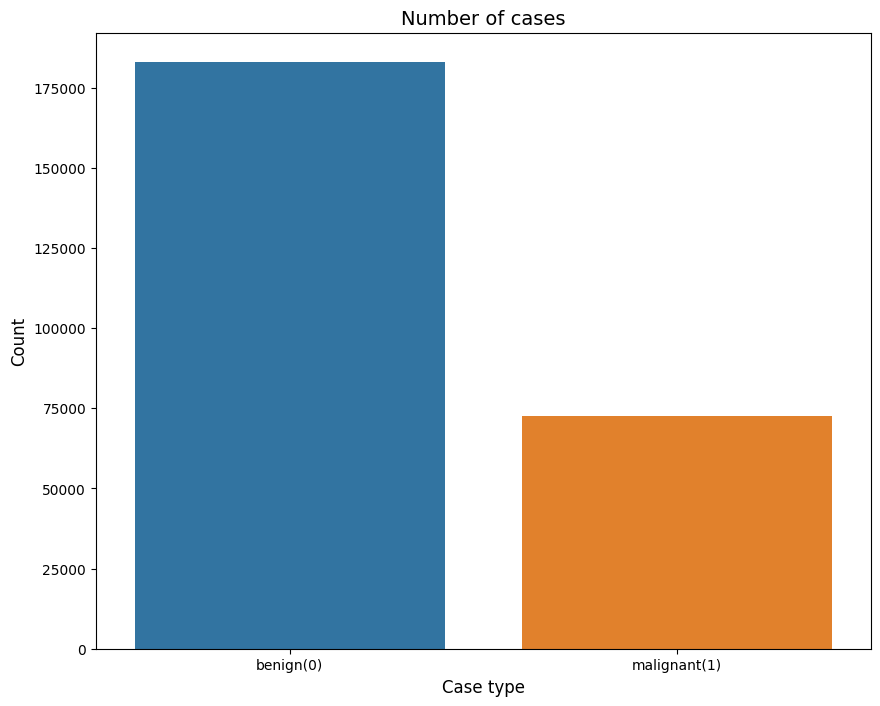

In [20]:
plotData(config.TRAIN_PATH)

0    71572
1    28213
Name: label, dtype: int64


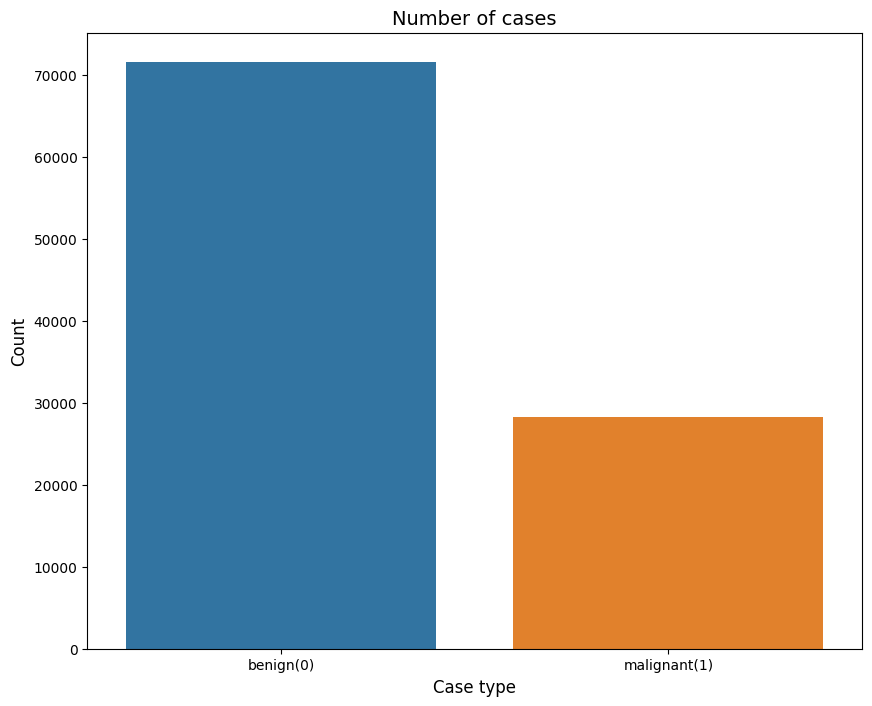

In [21]:
plotData(config.TEST_PATH)

0    30640
1    11994
Name: label, dtype: int64


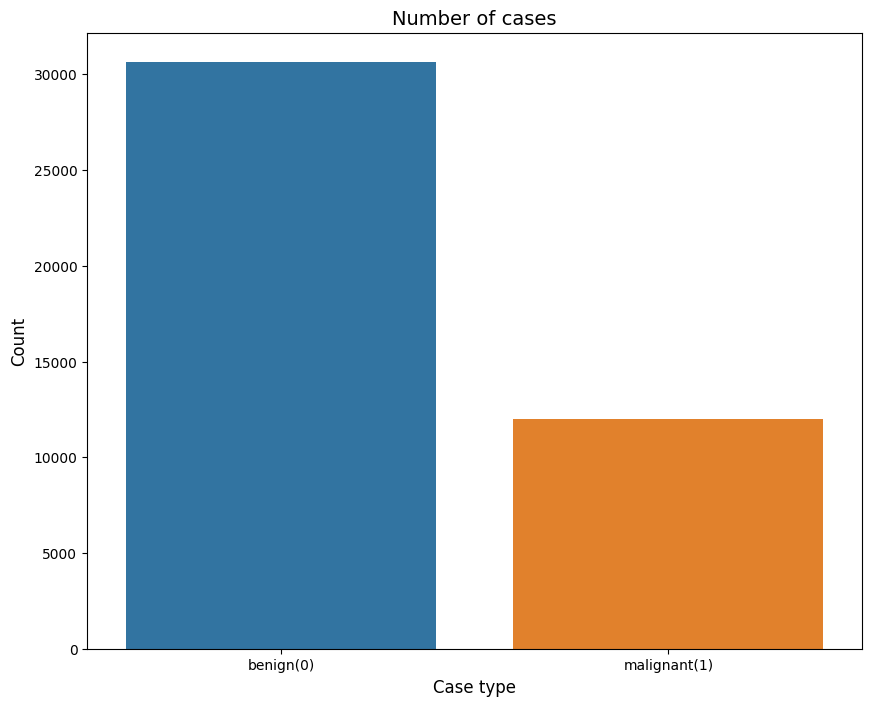

In [22]:
plotData(config.VAL_PATH)

In [23]:
# Get the path to the benign and malignant sub-directories
benign_cases_dir = config.TRAIN_PATH + '/0/'
malignant_cases_dir = config.TRAIN_PATH + '/1/'

# Get the list of all the images
benign_cases = glob.glob(benign_cases_dir + '*.png')
malignant_cases = glob.glob(malignant_cases_dir + '*.png')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data1 = []

# Go through all the benign cases. The label for these cases will be 0
for img in benign_cases:
    train_data1.append((img,0))

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:
    train_data1.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data1 = pd.DataFrame(train_data1, columns=['image', 'label'],index=None)

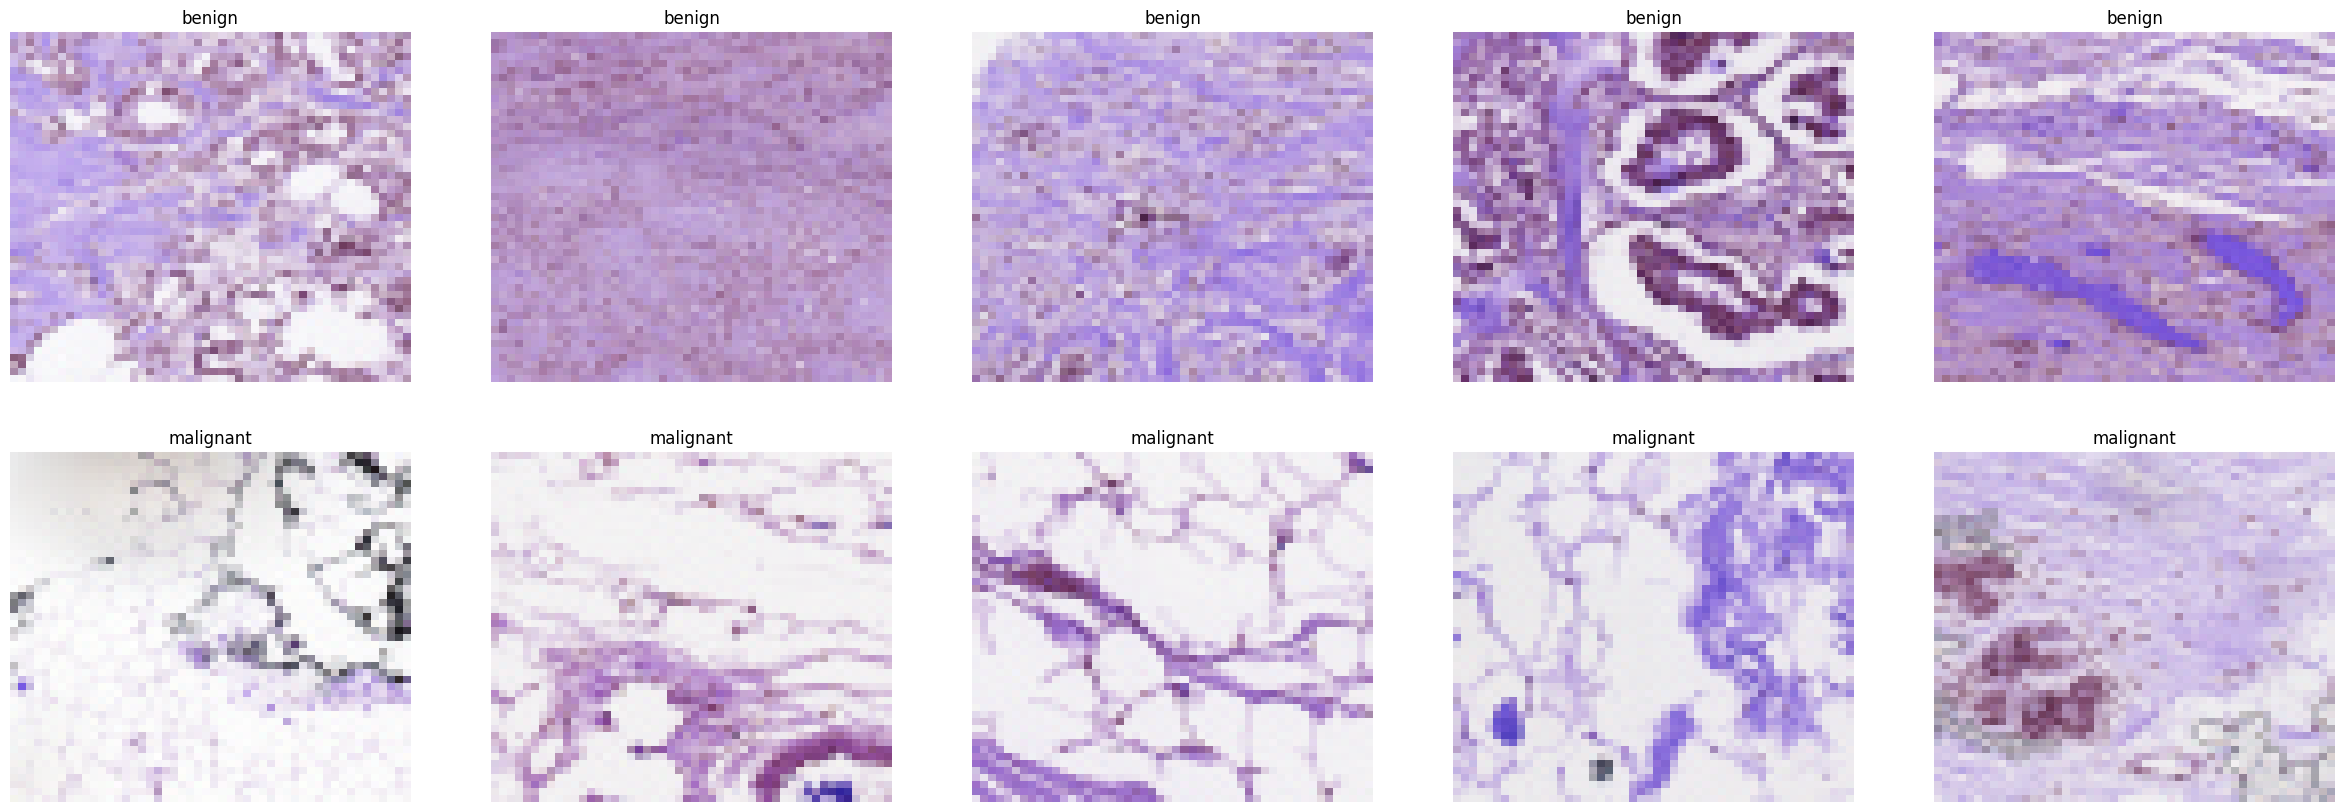

In [24]:
# Get few samples for both the classes
malignant_samples = (train_data1[train_data1['label']==1]['image'].iloc[:5]).tolist()
benign_samples = (train_data1[train_data1['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = malignant_samples + benign_samples
del malignant_samples, benign_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("benign")
    else:
        ax[i//5, i%5].set_title("malignant")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If we look carefully, then there are some cases where we won't be able to differentiate between a benign case and a malignant case with the naked eye. If we can build a robust classifier, it would be a great assist for the doctor too.

In [25]:
# Defining a method to get the number of files given a path
def retrieveNumberOfFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return len(list1)

In [26]:
# Defining a method to plot training and validation accuracy and loss
def training_plot(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [27]:
# Defining the paths to the training, validation, and testing directories
trainPath = config.TRAIN_PATH
valPath = config.VAL_PATH
testPath = config.TEST_PATH

In [28]:
# Checking for the total number of image paths in training, validation and testing directories
totalTrain = retrieveNumberOfFiles(config.TRAIN_PATH)
totalVal = retrieveNumberOfFiles(config.VAL_PATH)
totalTest = retrieveNumberOfFiles(config.TEST_PATH)

In [29]:
# Defining a method to get the list of files given a path
def getAllFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return list1

In [30]:
# Retrieving all files from train directory
allTrainFiles = getAllFiles(config.TRAIN_PATH)

In [31]:
# Calculating the total number of training images against each class and then store the class weights in a dictionary
trainLabels = [int(p.split(os.path.sep)[-2]) for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classSumTotals = trainLabels.sum(axis=0)
classWeight = dict()

# Looping over all classes and calculate the class weights
for i in range(0, len(classSumTotals)):
    classWeight[i] = classSumTotals.max() / classSumTotals[i]

In [32]:
# Initialize the training data augmentation object
## preprocess_input will scale input pixels between -1 and 1
## rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
## zoom_range is for randomly zooming inside pictures
## width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
## shear_range is for randomly applying shearing transformations
## horizontal_flip and vertical_flip is for randomly flipping half of the images horizontally and vertically resp
## fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

In [33]:
# Initialize the validation data augmentation object
valAug = ImageDataGenerator(rescale=1/255.0)

In [34]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=True,
	batch_size=config.BATCH_SIZE)

Found 255690 images belonging to 2 classes.


In [35]:
# Initialize the validation generator
valGen = valAug.flow_from_directory(
	valPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 42634 images belonging to 2 classes.


In [36]:
# Initialize the testing generator
testGen = valAug.flow_from_directory(
	testPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 99785 images belonging to 2 classes.


In [37]:
# Building the model
print("Building the model")
model = BC_Model.build(width=48, height=48, depth=3, classes=2)

Building the model


In [38]:
import tensorflow as tf


In [39]:
# Compiling the model
## Decay updates the learning rate by a decreasing factor in each epoch
print("Compiling the model")
opt = tf.keras.optimizers.legacy.Adam(lr=config.INIT_LR, decay=config.INIT_LR / config.EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling the model


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
# Using ModelCheckpoint to store the best performing model based on val_loss
MCName = os.path.sep.join([config.outputPath, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
checkpoint = ModelCheckpoint(MCName, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [41]:
# Fitting the model on training data
print("Fitting the Model")
MF = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // config.BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // config.BATCH_SIZE,
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=config.EPOCHS)

Fitting the Model
Epoch 1/20
7989/7990 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.8127
Epoch 1: val_loss improved from inf to 0.48774, saving model to /content/output/weights-001-0.4877.hdf5
7990/7990 [==============================] - 361s 44ms/step - loss: 0.6524 - accuracy: 0.8127 - val_loss: 0.4877 - val_accuracy: 0.8004
Epoch 2/20
7990/7990 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.8376
Epoch 2: val_loss improved from 0.48774 to 0.35807, saving model to /content/output/weights-002-0.3581.hdf5
7990/7990 [==============================] - 345s 43ms/step - loss: 0.5443 - accuracy: 0.8376 - val_loss: 0.3581 - val_accuracy: 0.8590
Epoch 3/20
7989/7990 [============================>.] - ETA: 0s - loss: 0.5141 - accuracy: 0.8477
Epoch 3: val_loss improved from 0.35807 to 0.35244, saving model to /content/output/weights-003-0.3524.hdf5
7990/7990 [==============================] - 345s 43ms/step - loss: 0.5141 - accuracy: 0.8477 - 

In [44]:
# Loading the best performing model
# Please specify the model name from the output folder which has the lowest val_loss
path1 = config.outputPath + '/weights-016-0.3072.hdf5'
fModel = load_model(path1)

In [45]:
# Predicting on the test data
print("Predicting on the test data")
predTest = fModel.predict(x=testGen, steps=(totalTest // config.BATCH_SIZE)+1)
predTest = np.argmax(predTest, axis=1)

Predicting on the test data
3119/3119 [==============================] - 49s 16ms/step


In [46]:
# Printing the Classification Report
print(classification_report(testGen.classes, predTest,target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91     71572
           1       0.76      0.83      0.79     28213

    accuracy                           0.88     99785
   macro avg       0.85      0.86      0.85     99785
weighted avg       0.88      0.88      0.88     99785



In [47]:
# Computing the confusion matrix and and using the same to derive the 
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[64306  7266]
 [ 4828 23385]]
acc: 0.8788
sensitivity: 0.8985
specificity: 0.8289


In [48]:
# Calculate roc auc
XGB_roc_value = roc_auc_score(testGen.classes, predTest)
print("XGboost roc_value: {0}" .format(XGB_roc_value))

XGboost roc_value: 0.8636765334659321


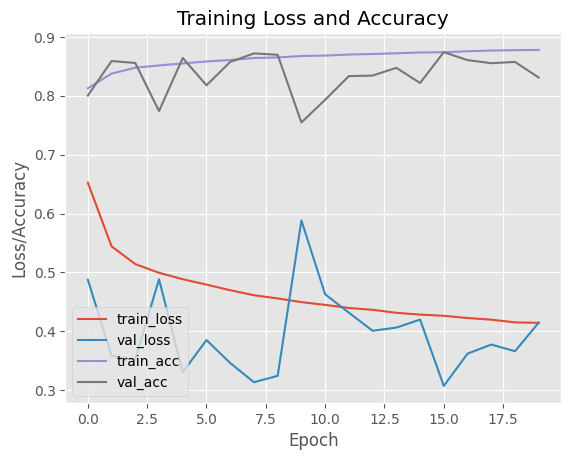

In [49]:
# Plotting the graph
training_plot(MF, config.EPOCHS, config.PLOT_PATH)

In [51]:
# Serialize/Writing the model to disk
print("Serializing network...")
fModel.save(config.MODEL_PATH, save_format="h5")

Serializing network...


In [52]:
cp '/content/output/weights-016-0.3072.hdf5' 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/output'